# Problem Setting: Representation Learning.

This notebook demonstrates that the Convolutional Ladder Networks can learn images and reconstruct its. Image dataset for this demo is the MNIST. The code of this notebook is written on the premise that the MNIST images are divided and arranged in directories for each label beforehand.

## Problem Solution: Convolutional Ladder Networks.

In most classification problems, finding and producing labels for the samples is hard. In many cases plenty of unlabeled data existand it seems obvious that using them should improve the results. For instance, there are plenty of unlabeled images available and in most image classification tasks there are vastly more bits of information in the statistical structure of input images than in their labels.

It is argued here that the reason why unsupervised learning has not been able to improve results is that most current versions are incompatible with supervised learning. The problem is that many un-supervised learning methods try to represent as much information about the original data as possible whereas supervised learning tries to filter out all the information which is irrelevant for the task at hand.

Ladder network is an Auto-Encoder which can discard information. Unsupervised learning needs to toleratediscarding information in order to work well with supervised learning. Many unsupervised learning methods are not good at this but one class of models stands out as an exception: hierarchical latent variable models. Unfortunately their derivation can be quite complicated and often involves approximations which compromise their per-formance.

A simpler alternative is offered by Auto-Encoders which also have the benefit of being compatible with standard supervised feedforward networks. They would be a promising candidate for combining supervised and unsupervised learning but unfortunately Auto-Encoders normally correspond to latent variable models with a single layer of stochastic variables, that is, they do not tolerate discarding information.

Ladder network makes it possible to solve that problem by settting recursive derivation of the learning rule with a distributed cost function, building denoisng Auto-Encoder recursively. Normally denoising Auto-Encoders have a fixed input but the cost functions on the higher layers can influence their input mappings and this creates a bias towards PCA-type solutions.

### Modeling and Implementation.

Firstly, import Python modules for building Convolutional Ladder Networks.

In [1]:
from accelbrainbase.computableloss._mxnet.l2_norm_loss import L2NormLoss
from accelbrainbase.extractabledata._mxnet.image_extractor import ImageExtractor
from accelbrainbase.iteratabledata._mxnet.unlabeled_image_iterator import UnlabeledImageIterator
from accelbrainbase.noiseabledata._mxnet.gauss_noise import GaussNoise
from accelbrainbase.observabledata._mxnet.convolutional_neural_networks import ConvolutionalNeuralNetworks
from accelbrainbase.observabledata._mxnet.convolutionalneuralnetworks.convolutionalautoencoder.convolutional_ladder_networks import ConvolutionalLadderNetworks

In [2]:
import mxnet as mx
import mxnet.ndarray as nd
import numpy as np
import pandas as pd
from mxnet.gluon.nn import Conv2D
from mxnet.gluon.nn import Conv2DTranspose
from mxnet.gluon.nn import BatchNorm

If you want to observe the learning log, set `getLogger`.

In [2]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("accelbrainbase")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)

Build and initialize `ImageExtractor`, specifying parameters such as image size.

In [4]:
image_extractor = ImageExtractor(
    # `int` of image width.
    width=28,
    # `int` of image height.
    height=28,
    # `int` of image channel.
    channel=1,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu()
)

Build and initialize `UnlabeledImageIterator`, delegating `image_extractor` and specifying parameters such as file path to image files.

In [5]:
unlabeled_image_iterator = UnlabeledImageIterator(
    # is-a `ImageExtractor`.
    image_extractor=image_extractor,
    # `list` of paths to image files in learning.
    dir_list=[
        "../../../../Downloads/digit-recognizer/train/0/", 
        "../../../../Downloads/digit-recognizer/train/1/", 
        "../../../../Downloads/digit-recognizer/train/2/", 
        "../../../../Downloads/digit-recognizer/train/3/", 
        "../../../../Downloads/digit-recognizer/train/4/", 
        "../../../../Downloads/digit-recognizer/train/5/", 
        "../../../../Downloads/digit-recognizer/train/6/", 
        "../../../../Downloads/digit-recognizer/train/7/", 
        "../../../../Downloads/digit-recognizer/train/8/", 
        "../../../../Downloads/digit-recognizer/train/9/", 
    ],
    # `list` of paths to image files in test.
    test_dir_list=[
        "../../../../Downloads/digit-recognizer/test/0/", 
        "../../../../Downloads/digit-recognizer/test/1/", 
        "../../../../Downloads/digit-recognizer/test/2/", 
        "../../../../Downloads/digit-recognizer/test/3/", 
        "../../../../Downloads/digit-recognizer/test/4/", 
        "../../../../Downloads/digit-recognizer/test/5/", 
        "../../../../Downloads/digit-recognizer/test/6/", 
        "../../../../Downloads/digit-recognizer/test/7/", 
        "../../../../Downloads/digit-recognizer/test/8/", 
        "../../../../Downloads/digit-recognizer/test/9/", 
    ],
    # `int` of epochs.
    epochs=1000,
    # `int` of batch size.
    batch_size=40,
    # How to normalize pixel values of images.
    # - `z_score`: Z-Score normalization.
    # - `min_max`: Min-max normalization.
    # - others : This class will not normalize the data.
    norm_mode="z_score",
    # `float` of scaling factor for data.
    scale=1.0,
    # is-a `NoiseableData`.
    noiseable_data=GaussNoise(sigma=1e-03, mu=0.0),
)

Build and initialize loss function.

In [6]:
computable_loss = L2NormLoss()

Build and initialize `ConvolutionalNeuralNetworks` as an encoder.

In [7]:
encoder = ConvolutionalNeuralNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `list` of int` of the number of units in hidden layers.
    hidden_units_list=[
        # `mxnet.gluon.nn.Conv2D`.
        Conv2D(
            channels=16,
            kernel_size=6,
            strides=(2, 2),
            padding=(1, 1),
        ), 
        Conv2D(
            channels=32,
            kernel_size=3,
            strides=(1, 1),
            padding=(1, 1),
        ),
    ],
    # `list` of act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    hidden_activation_list=["relu", "relu"],
    # `list` of `float` of dropout rate.
    hidden_dropout_rate_list=[0.0, 0.0],
    # `list` of `mxnet.gluon.nn.BatchNorm`.
    hidden_batch_norm_list=[BatchNorm(), BatchNorm()],
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `ConvolutionalNeuralNetworks` as a decoder.

In [8]:
decoder = ConvolutionalNeuralNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `list` of int` of the number of units in hidden layers.
    hidden_units_list=[
        # `mxnet.gluon.nn.Conv2DTranspose`.
        Conv2DTranspose(
            channels=16,
            kernel_size=3,
            strides=(1, 1),
            padding=(1, 1),
        ), 
        Conv2DTranspose(
            channels=1,
            kernel_size=6,
            strides=(2, 2),
            padding=(1, 1),
        ),
    ],
    # `list` of act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    hidden_activation_list=["relu", "identity"],
    # `list` of `float` of dropout rate.
    hidden_dropout_rate_list=[0.0, 0.0],
    # `list` of `mxnet.gluon.nn.BatchNorm`.
    hidden_batch_norm_list=[BatchNorm(), None],
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `ConvolutionalLadderNetworks`, delegating `encoder` and `decoder`.

In [9]:
CAE = ConvolutionalLadderNetworks(
    # is-a `ConvolutionalNeuralNetworks`.
    encoder=encoder,
    # is-a `ConvolutionalNeuralNetworks`.
    decoder=decoder,
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # is-a `mxnet.initializer` for parameters of model. If `None`, it is drawing from the Xavier distribution.
    initializer=None,
    # `float` of learning rate.
    learning_rate=1e-03,
    # `float` of attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=1.0,
    # `int` of attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # `bool` of flag to tied weights or not.
    tied_weights_flag=True,
    # `str` of name of optimizer.
    optimizer_name="SGD",
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Start learning.

In [10]:
CAE.learn(unlabeled_image_iterator)

Epochs: 100 Train loss: 0.64442253 Test loss: 0.61952555
Epochs: 200 Train loss: 0.44378892 Test loss: 0.41565514
Epochs: 300 Train loss: 0.34463024 Test loss: 0.34814414
Epochs: 400 Train loss: 0.29573816 Test loss: 0.28206903
Epochs: 500 Train loss: 0.25174826 Test loss: 0.248625
Epochs: 600 Train loss: 0.23534691 Test loss: 0.22489992
Epochs: 700 Train loss: 0.18623677 Test loss: 0.19648752
Epochs: 800 Train loss: 0.1915663 Test loss: 0.18746449
Epochs: 900 Train loss: 0.176123 Test loss: 0.17072818
Epochs: 1000 Train loss: 0.1926302 Test loss: 0.16292375
end. 


Visualize reconstruction losses.

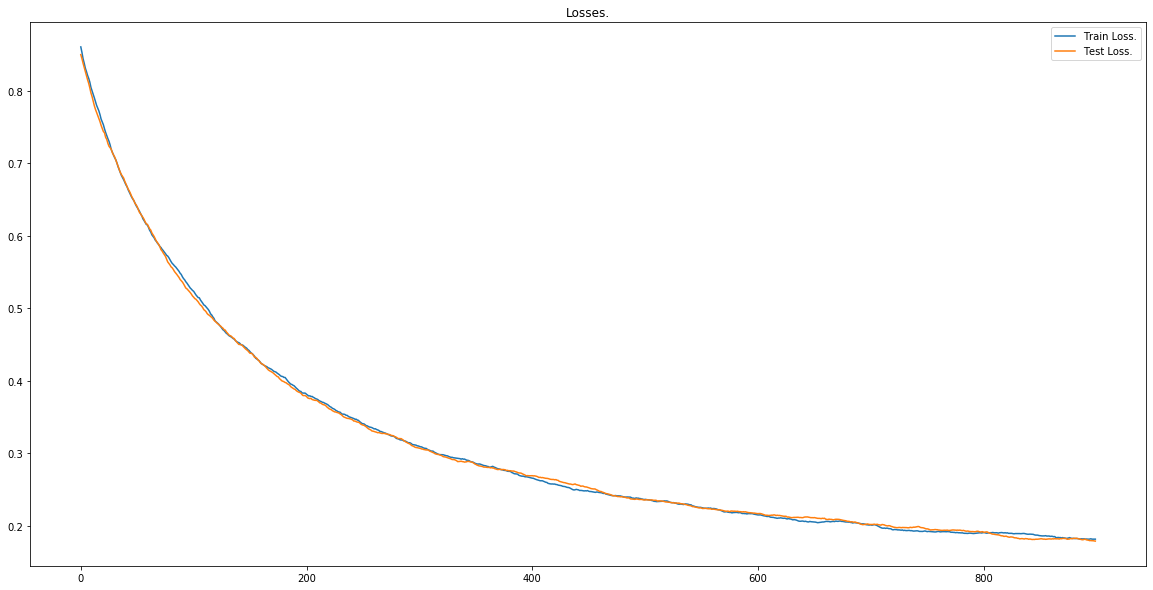

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def moving_avg(arr, window=50):
    return np.convolve(arr, np.ones(window) / window, mode='same')[window:-window]

plt.figure(figsize=(20, 10))
plt.plot(moving_avg(CAE.loss_arr[:, 0]), label="Train Loss.")
plt.plot(moving_avg(CAE.loss_arr[:, 1]), label="Test Loss.")
plt.legend()
plt.title("Losses.")
plt.show()

You can observe reconstructed images as follows.

In [12]:
test_arr = None
for _, _, _test_arr, _ in unlabeled_image_iterator.generate_learned_samples():
    test_arr = _test_arr
    break

In [13]:
inferenced_arr = CAE.inference(test_arr)

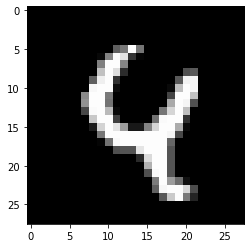

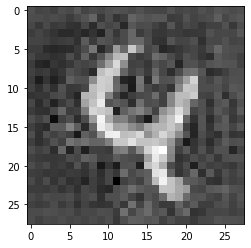

In [14]:
plt.imshow(test_arr[0].asnumpy().reshape(28, 28), cmap="gray")
plt.show()

plt.imshow(inferenced_arr[0].asnumpy().reshape(28, 28), cmap="gray")
plt.show()

**Note** that it is more important not to confirm the reconstructed image, but to confirm that the feature points obtained by representation learning are not excessive information loss, information overload, or noisy state.

You can also check the feature points as follows.

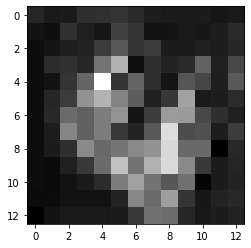

In [15]:
plt.imshow(CAE.feature_points_arr[0].asnumpy().mean(axis=0), cmap="gray")
plt.show()

## For ML Ops.

This model inherits [HybridBlock](https://gluon.mxnet.io/chapter07_distributed-learning/hybridize.html) from [mxnet.gluon](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/index.html). Functions for common ML Ops such as saving and loading parameters are provided by [HybridBlock](https://mxnet.apache.org/api/python/docs/api/gluon/hybrid_block.html).

# References

- Bengio, Y., Lamblin, P., Popovici, D., & Larochelle, H. (2007). Greedy layer-wise training of deep networks. In Advances in neural information processing systems (pp. 153-160).
- Dumoulin, V., & V,kisin, F. (2016). A guide to convolution arithmetic for deep learning. arXiv preprint arXiv:1603.07285.
- Erhan, D., Bengio, Y., Courville, A., Manzagol, P. A., Vincent, P., & Bengio, S. (2010). Why does unsupervised pre-training help deep learning?. Journal of Machine Learning Research, 11(Feb), 625-660.
- Erhan, D., Courville, A., & Bengio, Y. (2010). Understanding representations learned in deep architectures. Department dInformatique et Recherche Operationnelle, University of Montreal, QC, Canada, Tech. Rep, 1355, 1.
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning (adaptive computation and machine learning series). Adaptive Computation and Machine Learning series, 800.
- Masci, J., Meier, U., Cireşan, D., & Schmidhuber, J. (2011, June). Stacked convolutional auto-encoders for hierarchical feature extraction. In International Conference on Artificial Neural Networks (pp. 52-59). Springer, Berlin, Heidelberg.
- Rasmus, A., Berglund, M., Honkala, M., Valpola, H., & Raiko, T. (2015). Semi-supervised learning with ladder networks. In Advances in neural information processing systems (pp. 3546-3554).
- Valpola, H. (2015). From neural PCA to deep unsupervised learning. In Advances in Independent Component Analysis and Learning Machines (pp. 143-171). Academic Press.
